# Make Jet Images for Toy Model

In [1]:
import time
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sklearn
import pandas as pd

import os

In [2]:
# Set default options for paper
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'ytick.color':'k', 
         'xtick.color':'k', 
         'axes.labelcolor':'k',
         'text.color':'k'
         }
plt.rcParams.update(params)

In [3]:
def partition_exp(n_particles=10, nevents=1, mu=1.):
    evals = np.random.exponential(scale = mu, size=(nevents,n_particles))
    sumRow =np.repeat(evals.sum(axis=1), n_particles).reshape(nevents, n_particles)
    evals = np.sort(np.divide(evals,sumRow))[:, ::-1]
    return evals

In [4]:
def makeJetImages(grid = 32, n_data = 10, n_particles = 5, isSignal = False, overlap=0):

    '''inputs: image size, number of datapoints, number of particles in each subjet, signal or background, amount of overlap'''
    '''outputs: array of images, radii, theta, labels, summed image'''

    # origin
    center = int((grid-1)/2)
    labels = np.zeros(n_data*2).reshape((n_data,2))
    print(labels.shape)
    
    # create input variables
    if isSignal:
        if (overlap==0):
            theta = np.random.normal(loc=0.2, scale=0.02, size=n_data) # signal_d
            z = np.random.normal(loc=0.5, scale=0.02, size=n_data) #signal_z 
        elif(overlap==1):
            theta = np.random.normal(loc=0.2, scale=0.03, size=n_data) # signal_d_littleoverlap
            z = np.random.normal(loc=0.5, scale=0.09, size=n_data) #signal_z_littleoverlap
        elif(overlap==2):
            theta = np.random.normal(loc=0.2, scale=0.05, size=n_data) # signal_d_overlap
            z = np.random.normal(loc=0.5, scale=0.12, size=n_data) #signal_z_overlap
        labels[:,1]=1
    else:
        if (overlap==0):
            theta = np.random.exponential(scale=0.02, size=n_data) # bkg_d
            z = np.random.exponential(scale=0.02, size=n_data) #bkg_z
        elif(overlap==1):
            theta = np.random.exponential(scale=0.03, size=n_data) # bkg_d_littleoverlap
            z = np.random.exponential(scale=0.1, size=n_data) #bkg_z_olittleverlap
        elif(overlap==2):
            theta = np.random.exponential(scale=0.05, size=n_data) # bkg_d_overlap
            z = np.random.exponential(scale=0.15, size=n_data) #bkg_z_overlap
        labels[:,0]=1
    
    # masking z to ensure z<1.0
    z = np.where(z<1.0, z, z%1) #signal_z   
    # making so that z is always more than 1-z
    z = np.where(z>0.5, z, (1-z))
    z = np.repeat(z, n_particles).reshape(n_data, n_particles)
    # masking theta to ensure theta<0.5
    theta = np.where(theta<0.5, theta, theta%0.5)
    theta = np.repeat(theta, n_particles).reshape(n_data, n_particles)
    
    # distributing pT fractions between particles
    particles1 = np.multiply(partition_exp(n_particles, n_data), z)
    particles2 = np.multiply(partition_exp(n_particles, n_data), (1-z))
    
    # one jet has two subjets 
    radii = np.random.uniform(0.25,0.5 ,size = (n_data,2))
    radii1 = np.array([np.multiply(np.ones(shape = (n_particles)),y) for y in radii[:,0]])
    radii2 = np.array([np.multiply(np.ones(shape = (n_particles)),y) for y in radii[:,1]])
    dtheta1 = np.random.exponential(scale=0.5, size=(n_data, n_particles)) # delta theta for first subjet
    dtheta1= np.sort(np.where(dtheta1<radii1, dtheta1, dtheta1%radii1))
    phi1 = np.random.uniform(0, 2*math.pi, size=(n_data, n_particles)) # angular
    dtheta2 = np.random.exponential(scale=0.5, size=(n_data, n_particles)) # delta theta for second subjet
    dtheta2= np.sort(np.where(dtheta2<radii2, dtheta2, dtheta2%radii2))
    phi2 = np.random.uniform(0, 2*math.pi, size=(n_data, n_particles)) # angular
    
    # position of particles on the grid : subscripts 1, 2 for particles in jet1, jet2 respectively   
    x1 = (np.multiply(dtheta1, np.cos(phi1))*grid).astype(int) + center
    x2 = (np.multiply(dtheta2, np.cos(phi2))*grid).astype(int) + center
    y1 = (np.multiply(dtheta1, np.sin(phi1))*grid).astype(int) + center
    y2 = ((np.multiply(dtheta2, np.sin(phi2))-theta)*grid).astype(int) + center

    ybins1 = np.arange(0,grid+1)
    xbins1 = np.arange(0,grid+1)
    
    # H1, H2 are the images from the first and second subjet respectively  
    H1_ = (np.vstack(np.array([(np.histogram2d( y1[i], x1[i], bins=(xbins1, ybins1), weights = particles1[i])) for i in range(n_data)])[:,0])).reshape(n_data, grid, grid)
    H2_ = (np.vstack(np.array([(np.histogram2d( y2[i], x2[i], bins=(xbins1, ybins1), weights = particles2[i])) for i in range(n_data)])[:,0])).reshape(n_data, grid, grid)
    H_ = (H1_+H2_) # images witb both subjets
    # performing a parity flip so that the right side of the jet image has the highest sum pixel intensity
    H_parity = np.sum(H_, axis=1)
    if (grid%2==0):
        H_left_ = np.repeat(np.sum(np.sum(H_, axis=1)[:,:center+1], axis=1), grid**2).reshape(n_data,grid,grid)
    else:
        H_left_ = np.repeat(np.sum(np.sum(H_, axis=1)[:,:center], axis=1), grid**2).reshape(n_data,grid,grid)
    H_right_ = np.repeat(np.sum(np.sum(H_, axis=1)[:,center+1:], axis=1), grid**2).reshape(n_data,grid,grid)
    images = np.where(H_right_>H_left_, H_, np.flip(H_, axis=2))
    avgImages = np.sum(images, axis =0)
    z = z.reshape(n_data*n_particles,1)[::n_particles]
    theta = theta.reshape(n_data*n_particles,1)[::n_particles]

    return images, radii, z, theta, labels, avgImages

In [5]:
grid = 16
n_data = 20000
n_particles = 10
overlap = 0

## 'Signal' jet images and their plots

In [6]:
tic = time.perf_counter()
isSignal1 = True
images1, radii1, z1, theta1, labels1, avgImages1 = makeJetImages(grid, n_data, n_particles, isSignal1, overlap)
f = np.array(list(zip(images1, z1.flatten(), theta1.flatten(), radii1[:,0], radii1[:,1], labels1, avgImages1)))

toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )


(20000, 2)
Processing Time is  8.218890277668834 seconds for  20000  samples.


#### Average signal image - log scale norm

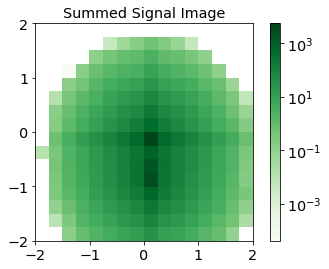

In [7]:
im1 = plt.imshow(avgImages1, interpolation='nearest', origin='low', norm=LogNorm(), cmap='Greens', extent = [-2.0, 2.0, -2.0, 2.0])
plt.title('Summed Signal Image')
plt.colorbar()
plt.show()

#### Individual 'signal' jet images

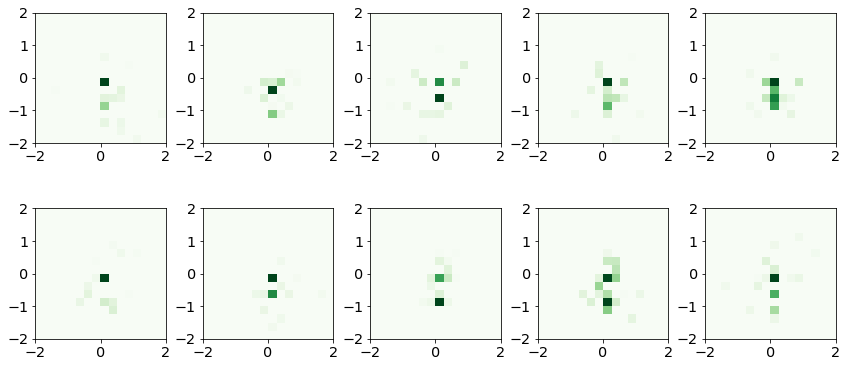

In [8]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images1[i], interpolation='nearest', origin='low', cmap='Greens', extent = [-2.0, 2.0, -2.0, 2.0])

## 'Background' jet images and their plots

In [9]:
if not os.path.exists("data"):
    os.mkdir("data")


tic = time.perf_counter()
isSignal2 = False
images2, radii2, z2, theta2, labels2, avgImages2 = makeJetImages(grid, n_data, n_particles, isSignal2, overlap)
toc = time.perf_counter()
g = np.array(list(zip(images2, z2.flatten(), theta2.flatten(), radii2[:,0], radii2[:,1], labels2, avgImages2)))
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )

(20000, 2)
Processing Time is  7.957826606929302 seconds for  20000  samples.


#### Average background image - log scale norm

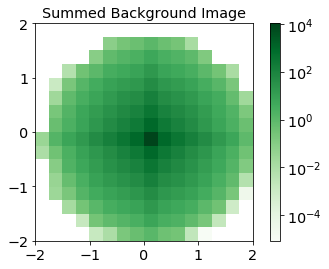

In [10]:
im1 = plt.imshow(avgImages2, interpolation='nearest', origin='low', norm=LogNorm(), cmap='Greens', extent = [-2.0, 2.0, -2.0, 2.0])
plt.title('Summed Background Image')
plt.colorbar()
plt.show()

#### Individual 'background' jet images

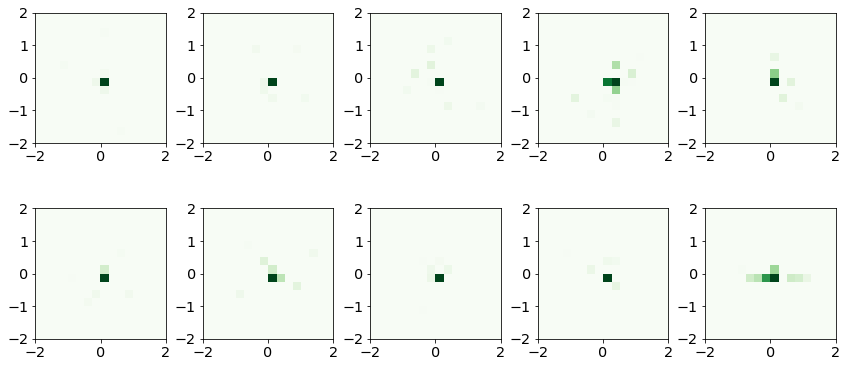

In [11]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images2[i], interpolation='nearest', origin='low', cmap='Greens', extent = [-2.0, 2.0, -2.0, 2.0])

### Creating samples for Testing

In [12]:
isSignal3 = True
images3, radii3, z3, theta3, labels3, avgImages3 = makeJetImages(grid, n_data, n_particles, isSignal3, overlap)
isSignal4 = False
images4, radii4, z4, theta4, labels4, avgImages4 = makeJetImages(grid, n_data, n_particles, isSignal4, overlap)

(20000, 2)
(20000, 2)


### Creating Plots of Input Variables

Text(0.5, 1.0, 'Toy Model Radii values')

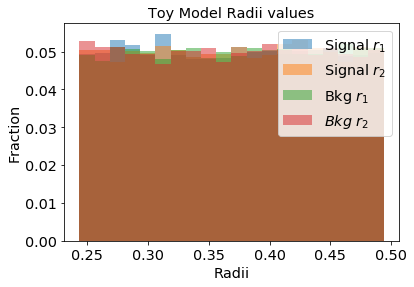

In [13]:
if not os.path.exists("plots"):
    os.mkdir("plots")
    
radii = [radii1[:,0], radii1[:,1], radii2[:,0],radii2[:,1]]
hist, bins = np.histogram([radii1[:,0], radii1[:,1], radii2[:,0],radii2[:,1]], bins=20)
hist1_1, bins1_1 = np.histogram(radii1[:,0], bins = 20)
hist1_2, bins1_2 = np.histogram(radii1[:,1], bins = bins1_1)
hist2_1, bins2_1 = np.histogram(radii2[:,0], bins = bins1_1)
hist2_2, bins2_2 = np.histogram(radii2[:,1], bins = bins1_1)
fig, ax = plt.subplots()
ax.bar(bins1_1[:-1], hist1_1/(np.sum(hist1_1)), width=np.diff(bins1_1), alpha = 0.5, label = r"Signal $r_1$")
ax.bar(bins1_2[:-1], hist1_2/(np.sum(hist1_2)), width=np.diff(bins1_2), alpha = 0.5, label = r"Signal $r_2$")
ax.bar(bins2_1[:-1], hist2_1/(np.sum(hist2_1)), width=np.diff(bins2_1), alpha = 0.5, label = r"Bkg $r_1$")
ax.bar(bins2_2[:-1], hist2_2/(np.sum(hist2_2)), width=np.diff(bins2_2), alpha = 0.5, label = r"$Bkg$ $r_2$")
plt.xlabel('Radii')
plt.ylabel("Fraction")
legend = plt.legend()
plt.title(r"Toy Model Radii values")


Text(0.5, 1.0, 'Toy Model $Z$')

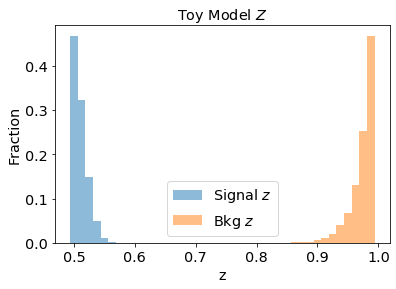

In [14]:
hist1, bins1 = np.histogram(z1, bins=40, range = [0.5,1])
hist2, bins2 = np.histogram(z2, bins=bins1)
fig, ax = plt.subplots()
ax.bar(bins1[:-1], hist1/(np.sum(hist1)), width=np.diff(bins1), alpha = 0.5, label = r"Signal $z$")
ax.bar(bins2[:-1], hist2/(np.sum(hist2)), width=np.diff(bins2), alpha = 0.5, label = r"Bkg $z$")
plt.xlabel('z')
plt.ylabel("Fraction")
legend = plt.legend()
plt.title(r"Toy Model $Z$")

Text(0.5, 1.0, 'Toy Model $\\theta$')

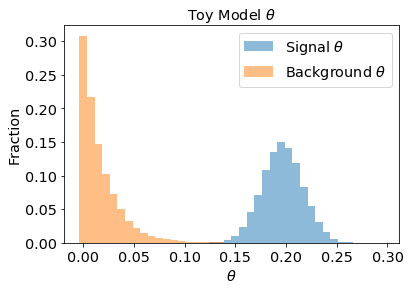

In [15]:
hist1, bins1 = np.histogram(theta1, bins=40, range = [0, 0.3])
hist2, bins2 = np.histogram(theta2, bins=bins1)
fig, ax = plt.subplots()
ax.bar(bins1[:-1], hist1/(np.sum(hist1)), width=np.diff(bins1), alpha = 0.5, label = r"Signal $\theta$")
ax.bar(bins2[:-1], hist2/(np.sum(hist2)), width=np.diff(bins2), alpha = 0.5, label = r"Background $\theta$")
plt.xlabel(r'$\theta$')
plt.ylabel("Fraction")
legend = plt.legend()
plt.title(r"Toy Model $\theta$")

In [16]:
trainlabels = np.concatenate((labels1,labels2),axis=0)
n_train = len(trainlabels)
trainimages = np.concatenate((images1, images2),axis=0).reshape(n_train, grid, grid, 1)
train_r = np.concatenate((radii1, radii2), axis = 0)
train_theta = np.concatenate((theta1, theta2), axis = 0)
train_z = np.concatenate((z1, z2), axis = 0)
trainlabels = trainlabels.reshape(n_train, 2)
# testing data
testlabels = np.concatenate((labels3, labels4),axis=0)
n_test = len(testlabels)
testimages = np.concatenate((images3, images4),axis=0).reshape(n_test, grid, grid, 1)
test_r = np.concatenate((radii3, radii4), axis = 0)
test_theta = np.concatenate((theta3, theta4), axis = 0)
test_z = np.concatenate((z3, z4), axis = 0)
testlabels = testlabels.reshape(int(n_test), 2)

In [ ]:
train_id = np.random.permutation(len(trainlabels))
test_id = np.random.permutation(len(testlabels))
print(np.max(trainimages))
train_features = [trainimages, train_theta, train_r, train_z, trainlabels]
test_features = [testimages, test_theta, test_r, test_z, testlabels]
for i in np.arange(len(train_features)):
    train_features[i] = train_features[i][train_id]
    test_features[i] = test_features[i][test_id]
print(np.max(train_features[0]))

0.980118362979479


In [ ]:
np.savez('data/jetImagesTrain', jetImages = train_features[0], thetalab = train_features[1], radiilab = train_features[2], zlab = train_features[3], labels = train_features[4])
np.savez('data/jetImagesTest', jetImages = test_features[0], thetalab = test_features[1], radiilab = test_features[2], zlab = test_features[3], labels = test_features[4])
